### Import Libraries

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler # Which one should i use? 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

### Load the data

In [203]:
# Read the data
df = pd.read_csv('Churn_Modelling_v1.csv')
df.head()

,Exited,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,15634602,Hargrave,619,0,1,42,2,0.00,1,1,1,101348.88
1,0,15647311,Hill,608,2,1,41,1,83807.86,1,0,1,112542.58
2,1,15619304,Onio,502,0,1,42,8,159660.80,3,1,0,113931.57
3,0,15701354,Boni,699,0,1,39,1,0.00,2,0,0,93826.63
4,0,15737888,Mitchell,850,2,1,43,2,125510.82,1,1,1,79084.10


In [204]:
df.describe()

,Exited,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.203700,1.569094e+07,650.528800,0.746300,0.454300,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,0.402769,7.193619e+04,96.653299,0.827529,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,0.000000,1.556570e+07,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,0.000000,1.562853e+07,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,0.000000,1.569074e+07,652.000000,0.000000,0.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,0.000000,1.575323e+07,718.000000,1.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,1.000000,1.581569e+07,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


###### Checking for Class imbalance

- 20% Exited (1)
- 80% Non Exited (0)

In [205]:
print("1 : ", len(df[df.Exited == 1]) / 10000)
print("0 : ",len(df[df.Exited == 0]) / 10000)

1 :  0.2037
0 :  0.7963


###### Drop unwanted columns

Created a numpy array X which contains all of the columns of df except for Surname, Exited and Customer Id. Exited is the response variable while Surname and Customer ID don't give us any useful information. Hence, they are noise so dropped and not included in training the model

In [206]:
X = df.drop(['Surname','Exited', 'CustomerId'], axis=1)
y = df['Exited']
print(X.shape)
print(y.shape)

(10000, 10)
(10000,)


##### Standardize data

Though the need to standardize the data isn't so great in classification problems, I did standardize the data using the robust scaler method as it also deals with outliers in the dataset. 

In [207]:
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)

##### Split the data into training and test sets

In [208]:
# Split the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123, stratify=y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape) 

(8000, 10)
(8000,)
(2000, 10)
(2000,)


### Base Classifier 
- Use Logistic Regression as the base classifier 
- Training Logistic Regression Classifier and fit on X_train, y_train (data before SMOTEENN)


In [209]:
log_reg = LogisticRegression(class_weight='balanced', 
                             C=0.01)

log_reg.fit(X_train,y_train)
print("\n\n -- Logistic Regression Model --")
log_reg_auc_score = roc_auc_score(y_test,log_reg.predict(X_test))
print("-- Logistic Regression Model AUC = %2.2f --" % log_reg_auc_score)
print(classification_report(y_test, log_reg.predict(X_test)))



 -- Logistic Regression Model --
-- Logistic Regression Model AUC = 0.68 --
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1593
           1       0.36      0.65      0.47       407

    accuracy                           0.70      2000
   macro avg       0.63      0.68      0.63      2000
weighted avg       0.78      0.70      0.72      2000



##### Handle class imbalance 

- Used SMOTEENN which combines over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [210]:
# class imbalance 
from imblearn.combine import SMOTEENN
print(X_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))

sm_upsample = SMOTEENN(sampling_strategy='all') 
X_res, y_res = sm_upsample.fit_resample(X_train, y_train)

print('Shape of X after over sampling ', X_res.shape)
print('Shape of y after over sampling', y_res.shape)
print(sum(y_res == 1))
print(sum(y_res == 0))



(8000, 10)
(8000,)
1630
6370
Shape of X after over sampling  (9826, 10)
Shape of y after over sampling (9826,)
5544
4282


## Perform Hyper-Parameter Tuning for other classifiers

In [215]:
# -- Hyper-parameter tuning for Decision Tree Classifier -- 

classifier=DecisionTreeClassifier()
grid_param = {'criterion': ['gini', 'entropy'],
             'class_weight': ['balanced', 'None'],
             'max_depth' : [None, 2, 4, 6, 8, 10],
             'min_weight_fraction_leaf': [0.001, 0.01 , 0.1]}
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)
# Find the best hyperparamer value of C for logistic regression 
gd_sr.fit(X_res, y_res)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_weight_fraction_leaf': 0.001}


In [216]:
# -- Hyper-parameter tuning for AdaBoostClassifier -- 


classifier=AdaBoostClassifier()
grid_param = {'n_estimators': [200, 400, 600, 800, 1000],
             'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(X_res, y_res)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'learning_rate': 0.1, 'n_estimators': 1000}


In [218]:
# -- Hyper-parameter tuning for Random Forest Classifier -- 

classifier=RandomForestClassifier()

grid_param = {'n_estimators': [100, 500, 1000],
             'class_weight': ['balanced', 'None'],
             'max_depth' : [None, 2, 4, 6, 8,  10],
             'min_samples_split': [10, 20, 50, 100],
             'min_weight_fraction_leaf': [0.001, 0.01 , 0.1]}

gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(X_res, y_res)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.001, 'n_estimators': 500}


In [248]:
# -- Hyper-parameter tuning for Support Vector Machine Classifier -- 

from sklearn.svm import SVC

classifier=SVC()

grid_param = {'C': [0.0001, 0.001, 0.01, 0.1],
             'class_weight': ['balanced', 'None']}

gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(X_res, y_res)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'C': 0.1, 'class_weight': 'balanced'}


### Decision Tree vs Random Forest vs AdaBoost vs SVM

In [243]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Training Decision Tree Classifier
dt = DecisionTreeClassifier(class_weight = 'balanced',
                                criterion = 'gini', 
                                max_depth = 8, # was 10 used 8 
                                min_weight_fraction_leaf = 0.01) # was 0.001 used 0.01

dt.fit(X_res,y_res)
print ("\n\n ---Decision Tree Model---")
dt_auc_score = roc_auc_score(y_test, dt.predict(X_test))
print ("Decision Tree AUC = %2.2f" % dt_auc_score)
print(classification_report(y_test, dt.predict(X_test)))


# Training AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators = 500,
                         learning_rate = 0.1)

ada.fit(X_res,y_res)
print ("\n\n ---AdaBoost Tree Model---")
ada_auc_score = roc_auc_score(y_test, ada.predict(X_test))
print ("AdaBoostClassifier AUC = %2.2f" % ada_auc_score)
print(classification_report(y_test, ada.predict(X_test)))


# Training Random Forest Classifier
rf = RandomForestClassifier(n_estimators = 500,
                            max_depth=None,
                            min_samples_split = 10,
                            class_weight='balanced',
                            min_weight_fraction_leaf = 0.001)
                         

rf.fit(X_res,y_res)
print ("\n\n ---Random Forest Model---")
rf_auc_score = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_auc_score)
print(classification_report(y_test, rf.predict(X_test)))


# Training SVM Classifier
svm = SVC(C=0.1, class_weight='balanced',probability=True)

svm.fit(X_res,y_res)
print ("\n\n ---SVM Model---")
svm_auc_score = roc_auc_score(y_test, svm.predict(X_test))
print ("SVM AUC = %2.2f" % svm_auc_score)
print(classification_report(y_test, svm.predict(X_test)))



 ---Decision Tree Model---
Decision Tree AUC = 0.77
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1593
           1       0.47      0.74      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.71      2000
weighted avg       0.83      0.78      0.80      2000



 ---AdaBoost Tree Model---
AdaBoostClassifier AUC = 0.77
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1593
           1       0.43      0.80      0.56       407

    accuracy                           0.75      2000
   macro avg       0.68      0.77      0.69      2000
weighted avg       0.83      0.75      0.77      2000



 ---Random Forest Model---
Random Forest AUC = 0.77
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1593
           1       0.48      0.74      0.58       407

    accuracy   

### ROC Graph for all models

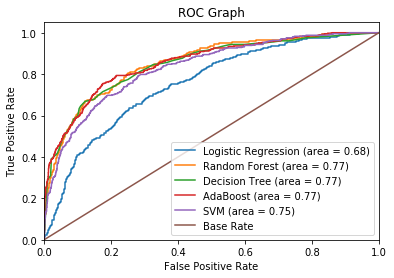

In [244]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, ada.predict_proba(X_test)[:,1])
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])


plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % log_reg_auc_score)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_auc_score)

# # Plot Decision Tree ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_auc_score)

# Plot AdaBoost ROC
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (area = %0.2f)' % ada_auc_score)

# Plot SVM ROC
plt.plot(svm_fpr, svm_tpr, label='SVM (area = %0.2f)' % svm_auc_score)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

### Visualize Decision Tree Feature Importance

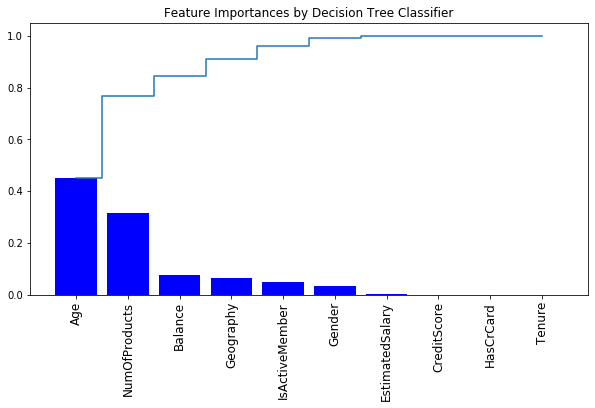

In [249]:
# Plot Decision Tree feature importance

importances = dt.feature_importances_
feature_names = df.drop(['Surname','Exited', 'CustomerId'], axis=1).columns

indices = np.argsort(importances)[::-1]

# Create plot
plt.figure(figsize=(10,5))

# Create plot title
plt.title("Feature Importances by Decision Tree Classifier")

# Add bars
plt.bar(range(len(indices)), importances[indices], color='blue', align='center')

# Add step
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')

# Add feature names as x-axis labels
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical', fontsize = 12)

# Show plot
plt.show()